In [122]:
import pandas as pd
import os
from os.path import isfile, join
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh, inv, eigvals, eigh, eig, norm

In [1]:
data_dir = r'D:\data\iqfeed\daily\cleaned'

In [18]:
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]

In [20]:
dfs = []
for f in onlyfiles:
    try:
        prices_path = os.path.join(data_dir, f)
        prices = pd.read_parquet(prices_path, columns=['adj_close'])
        prices.columns = f.split('.')[0]
    except Exception as e:
        continue
    dfs.append(prices)

In [21]:
dfs = pd.concat(dfs, axis=1)
dfs.columns = range(dfs.shape[1])

In [26]:
dfs.sort_index(inplace=True)

In [29]:
dfs.apply(lambda x: np.log(x).diff())

c:\Users\Adria\Documents\Github Projects\RandomMatrixTheory\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Adria\Documents\Github Projects\RandomMatrixTheory\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,0,1,2,3,4,5,6,7,8,9,...,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162
2010-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05 00:00:00,0.006438,0.025342,0.047690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009390,-0.005680
2010-01-06 00:00:00,0.005333,0.001923,0.035218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063370,0.222330
2010-01-07 00:00:00,-0.006403,0.061472,0.013801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.002548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017392,-0.045993
2010-01-08 00:00:00,0.000000,0.000000,-0.019813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.005115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017094,0.005442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-11 00:00:00,0.008114,-0.011587,0.011183,NaN,NaN,NaN,NaN,-0.008097,NaN,0.001537,...,0.005510,NaN,-0.084274,-0.038119,NaN,NaN,0.008163,-0.007564,0.022832,-0.019834
2023-12-12 00:00:00,0.000632,-0.011723,-0.009968,0.000000,NaN,NaN,NaN,0.020121,NaN,0.043583,...,-0.007421,NaN,-0.140384,-0.012346,NaN,NaN,-0.022314,-0.003259,0.034391,-0.021311
2023-12-13 00:00:00,0.011134,0.057904,0.015962,-0.001855,NaN,NaN,NaN,0.065534,NaN,0.032553,...,0.025737,NaN,0.062423,0.030583,NaN,NaN,0.067725,0.006508,0.035355,0.057547
2023-12-14 00:00:00,0.028103,0.082726,0.068136,-0.002789,NaN,NaN,NaN,0.001864,NaN,0.053355,...,0.007233,NaN,-0.028077,-0.034733,NaN,NaN,-0.013408,-0.025179,0.065196,0.013132


In [33]:
dfs = dfs.apply(lambda x: np.log(x).diff())

c:\Users\Adria\Documents\Github Projects\RandomMatrixTheory\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Adria\Documents\Github Projects\RandomMatrixTheory\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [65]:
C = dfs.iloc[10:15, :].dropna(axis=1).to_numpy().T @ dfs.iloc[10:15, :].dropna(axis=1).to_numpy()
# np.trace(C)
# np.linalg.norm(C, ord='fro')

47.18167476458507

In [111]:
def my_f(X):
    C = X.dropna(axis=1).to_numpy().T @ X.dropna(axis=1).to_numpy()# np.trace(C)
    return np.array([np.trace(C)/C.shape[0], np.linalg.norm(C, ord='fro')/C.shape[0], C.shape[0]])

In [112]:
def rolling_pipe(dataframe, window, fctn):
    return pd.DataFrame(
        data=np.stack(
            [dataframe.iloc[i-window: i].pipe(fctn) if i >= window else np.array([np.nan, np.nan]) for i in range(1, len(dataframe)+1)], 
            axis=0),
        columns=["Trace", "Frob", "N"],
        index = dataframe.index)

In [114]:
c_props = dfs.iloc[-1000:, :].pipe(rolling_pipe, 3, my_f)

C:\Users\Adria\AppData\Local\Temp\ipykernel_113764\1128340392.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.array([np.trace(C)/C.shape[0], np.linalg.norm(C, ord='fro')/C.shape[0]])
C:\Users\Adria\AppData\Local\Temp\ipykernel_113764\1128340392.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.array([np.trace(C)/C.shape[0], np.linalg.norm(C, ord='fro')/C.shape[0]])
C:\Users\Adria\AppData\Local\Temp\ipykernel_113764\1128340392.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.array([np.trace(C)/C.shape[0], np.linalg.norm(C, ord='fro')/C.shape[0]])


<Axes: >

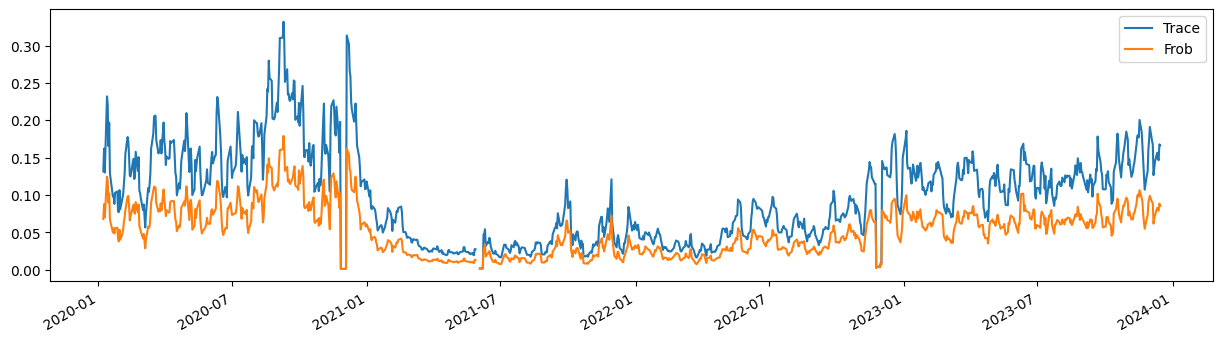

In [120]:
c_props.plot(figsize=(15, 4))

In [250]:
cutoff = -3000
X = (dfs.iloc[cutoff:].isna()).sum(axis=0) < 64
df = dfs.iloc[cutoff:, ].loc[:, X]
df = df.dropna()
df.shape

(2935, 2034)

In [275]:
C = df.T @ df / df.shape[0]

In [277]:
eig_vals, eig_vecs = eigh(C)

In [264]:
eig_vals = eig_vals.real

In [286]:
eig_vecs.shape

(2034, 2034)

In [296]:
market_portfolio = eig_vecs @ df.T
c_props = df.pipe(rolling_pipe, 3, my_f)

Text(0, 0.5, 'Y2 data')

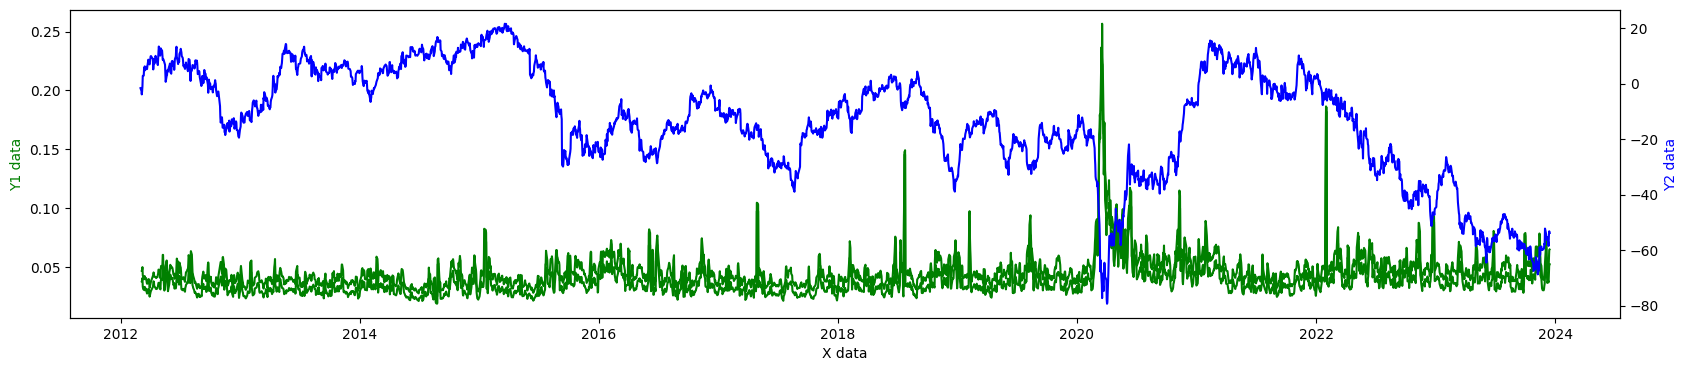

In [309]:
fig, ax1 = plt.subplots(figsize=(20, 4))

ax2 = ax1.twinx()
ax1.plot(c_props, 'g-')
ax2.plot(market_portfolio.sum().cumsum(), 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')